In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


In [13]:
_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_ENDPOINT")
_set_env("LANGSMITH_API_KEY")
_set_env("LANGSMITH_PROJECT")

In [7]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [9]:
from googleapiclient.discovery import build 
from comentary_extractor import CommentExtractor, CommentExtractorResponse

_set_env("YOUTUBE_API_KEY")

def comentaries(video_url: str, next_page_token: str | None = None) -> CommentExtractorResponse:
    """
    Extracts the comments from a YouTube video given its URL.

    Args:
        video_url: (str) The URL of the YouTube video.
        next_page_token: (str | None) The token for pagination, if provided search the next commentaries

    Returns:
        ComentExtractorResponse: A dict containing the comments and next_page_token (can be None).
    """

    youtube = build('youtube', 'v3', developerKey=os.getenv("YOUTUBE_API_KEY"))
    extractor = CommentExtractor(
        video_url,
        youtube=youtube
    )
    response = extractor.extract(next_page_token)

    return response

In [10]:
tools = [comentaries]
chat = llm.bind_tools(tools)

In [20]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage

SYSTEM = SystemMessage(content="You are an Digital Marketeer tasked with the activity to extract the feeling of a youtube video commentaries. If you need more comentaries you are an Digital Marketeer")

def assistant(state: MessagesState):
    return {"messages": [
        chat.invoke([SYSTEM] + state["messages"])
    ]}

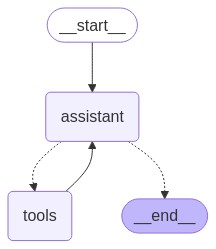

In [16]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)

builder.add_edge("tools", "assistant")

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [18]:
messages = [HumanMessage(content="Poderia analizar os comentários desse vídeo: https://www.youtube.com/watch?v=ML8h9pgWyXw")]
messages = graph.invoke({"messages": messages})

In [19]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Poderia analizar os comentários desse vídeo: https://www.youtube.com/watch?v=ML8h9pgWyXw
================================== Ai Message ==================================
Tool Calls:
  comentaries (call_9iis0e5oX7zmfavb6xKcAQ8q)
 Call ID: call_9iis0e5oX7zmfavb6xKcAQ8q
  Args:
    video_url: https://www.youtube.com/watch?v=ML8h9pgWyXw
================================= Tool Message =================================
Name: comentaries

{"comments": [{"id": "UgyxNvPyNr12RycRUx14AaABAg", "text": "Meetup da FIAP + Alura. Se inscreva!\nhttps://www.sympla.com.br/evento/meetup-de-comunidades-dominando-flutter-da-personalizacao-de-dados-a-construcao-de-carreira/2871457", "user_name": "@FlutterandoTV", "date": "2025-03-26T00:14:22Z", "replies": []}, {"id": "UgzIO80Z-3K6ZG5j8Xt4AaABAg", "text": "vida longa ao dart 🚀", "user_name": "@merengdev", "date": "2025-03-26T11:37:45Z", "replies": []}, {"id": "Ugyj_-RPQzfBp8Yuj7R